#### Let's import the libraries

In [1]:
!pip install pmdarima --q 
!pip install prophet --q 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8);  

from datetime import datetime, date 

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Neural network required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings("ignore")

#### Loading Dataset

In [4]:
df = pd.read_excel('/kaggle/input/air-quality-forecasting-co2-emissions/CO2 dataset.xlsx')

In [5]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [7]:
df.duplicated().sum()

0

In [9]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y') # converting year column to datetime format

In [ ]:
df.set_index(['Year'], inplace=True) # changing index to datetime 

In [12]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [13]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [15]:
# checking if data is continues
if (df.index.max() - df.index.min() == 214): 
    print('Data Is Continuous')

In [16]:
df.index.freq='YS' # setting the data frequency to year

#### Analysis Results:

1. No null values
2. length of df is 215
3. No duplicate values present
4. Data is continuous, ranging from 1800 to 2014

### Time Series Analysis

#### Let's visualize the data

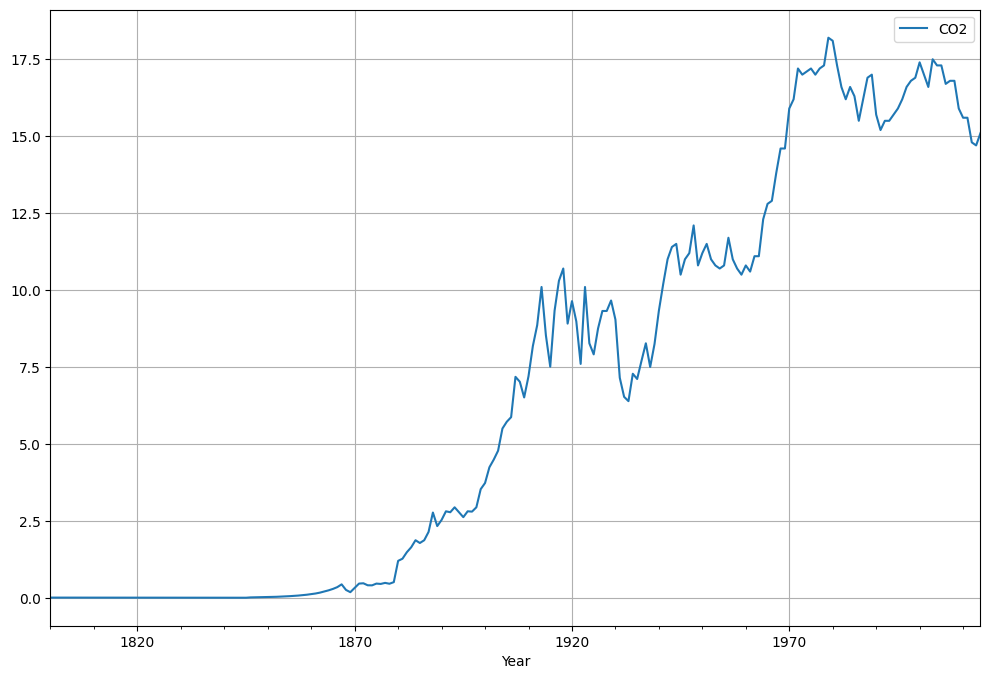

In [17]:
df.plot(grid=True);

#### Plot Analysis
1. Exponential trend is present and maybe cyclicity too
2. From the start to 1870 the data is constant(almost 0), theres no variance either
3. After 1970 the trend seems to be constant. It might be cause of different goverment laws on manufacturing comapnies regarding pollution control.

In [18]:
# Train test split the dataset
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

#### Time Series Decomposition:
A time series is usually composed of the following components:

1) Trend : This component usually is increasing, decreasing, or constant.
2) Seasonality : This is the periodic behavior of the time series that occurs within a year.
3) Residual : This is what remains of the time series after the trend and seasonality are removed.

The basic approach to seasonal decomposition splits the time series into above components.

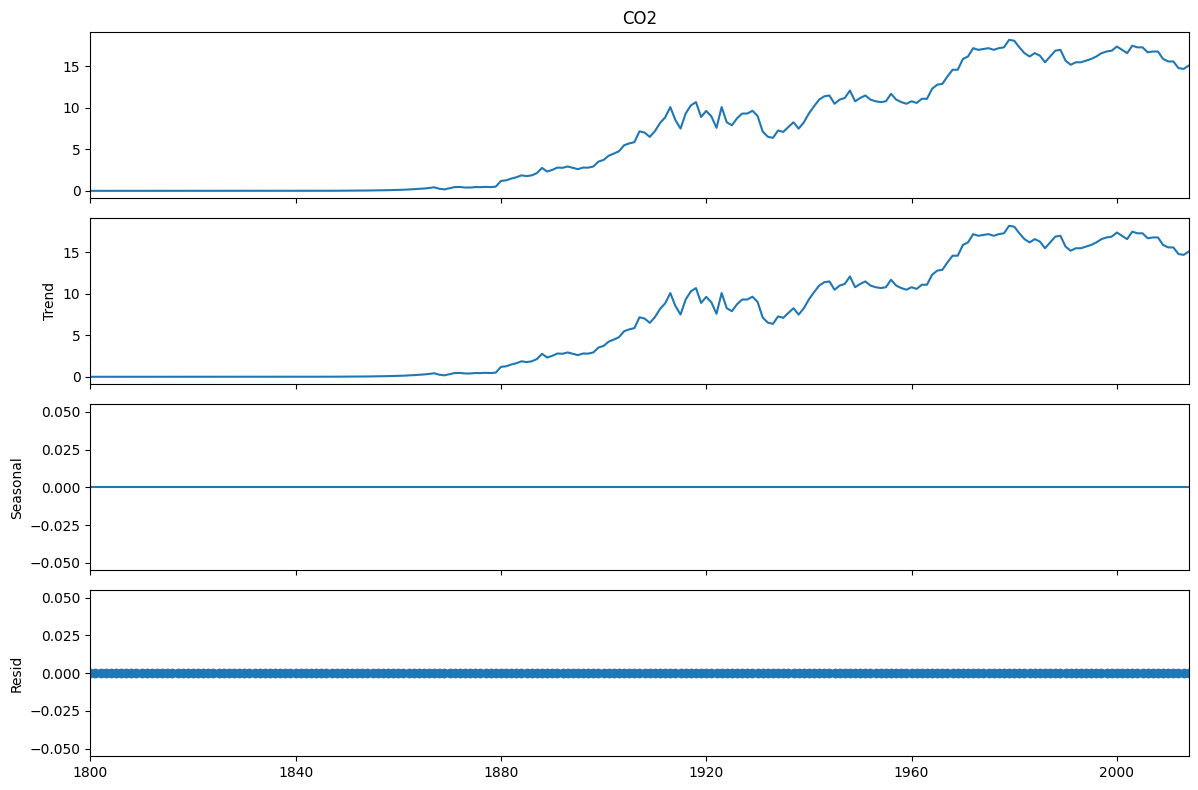

In [19]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot();

#### Stationary Time Series :
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series. A more accurate method would be to use a statistical test, such as the Dickey-Fuller test.

ADFuller Test:
If Test statistic < Critical Value and p-value < 0.05 – then series is stationaryionary

In [20]:
# functon for adf test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.values)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


#### Result Explaination:
The p-value obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Hence the series is not stationary

#### Differencing :
Differencing is a method of transforming a time series dataset. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Depending on the number of diferencing required to make series stationary,we get value of 'd'. Which is a required parameter in ARIMA model

In [21]:
diff_df = df.diff() #first differencing for stationarity
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [22]:
diff_df.dropna(inplace=True)

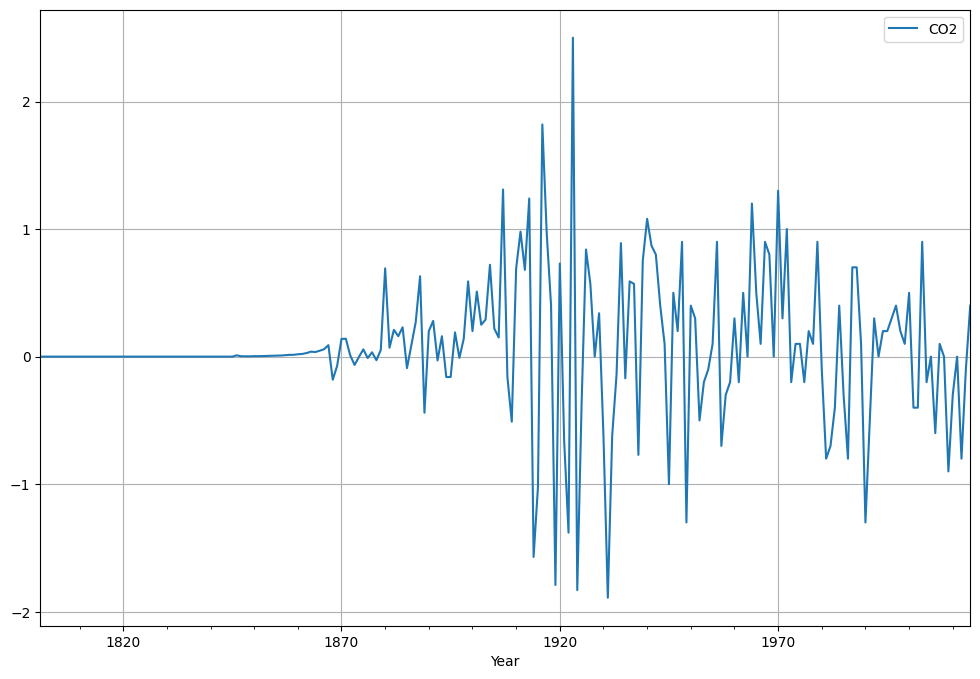

In [23]:
diff_df.plot(grid=True);

In [24]:
adf_test(diff_df)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


#### Result Analysis
The p-value obtained is less than significance level of 0.05 and the ADF statistic is less than any of the critical values. Hence the first ordered differenced series is stationary and d=1

**Autocorrelation and Partial Autocorrelation Function:**
Autocorrelation and partial autocorrelation are plots that graphically summarize the impact of observations at prior timesteps on the observations we are trying to predict.
**ACF plot gives the q value and PACF gives the p value:**
lue
Look for tail of pattern in either ACF or PACF. If tail is crossing the blue region then it will give us potential p and q values.

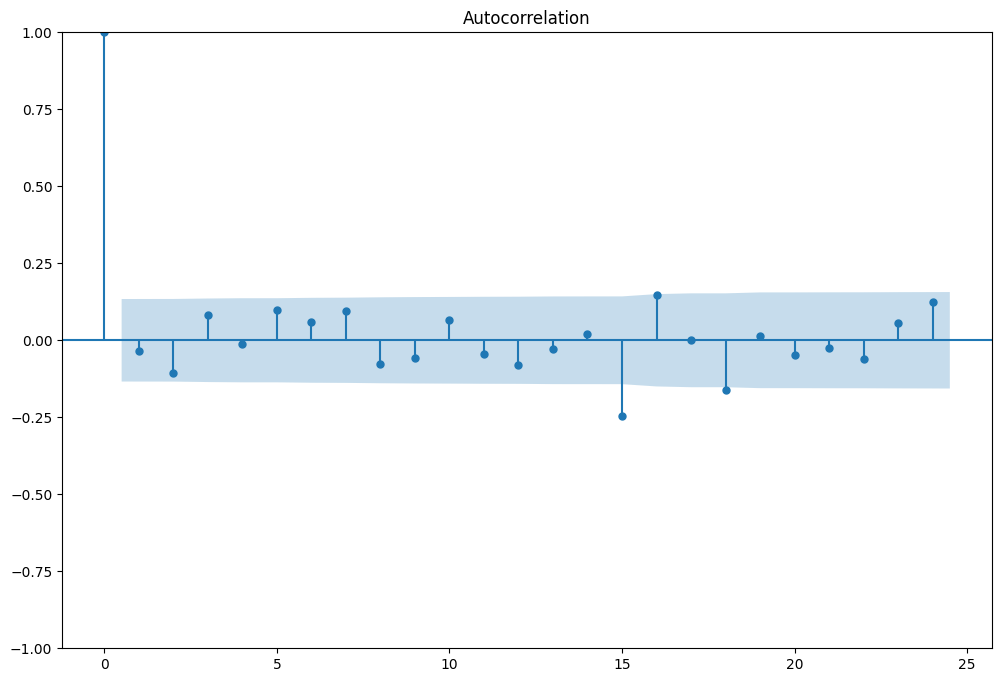

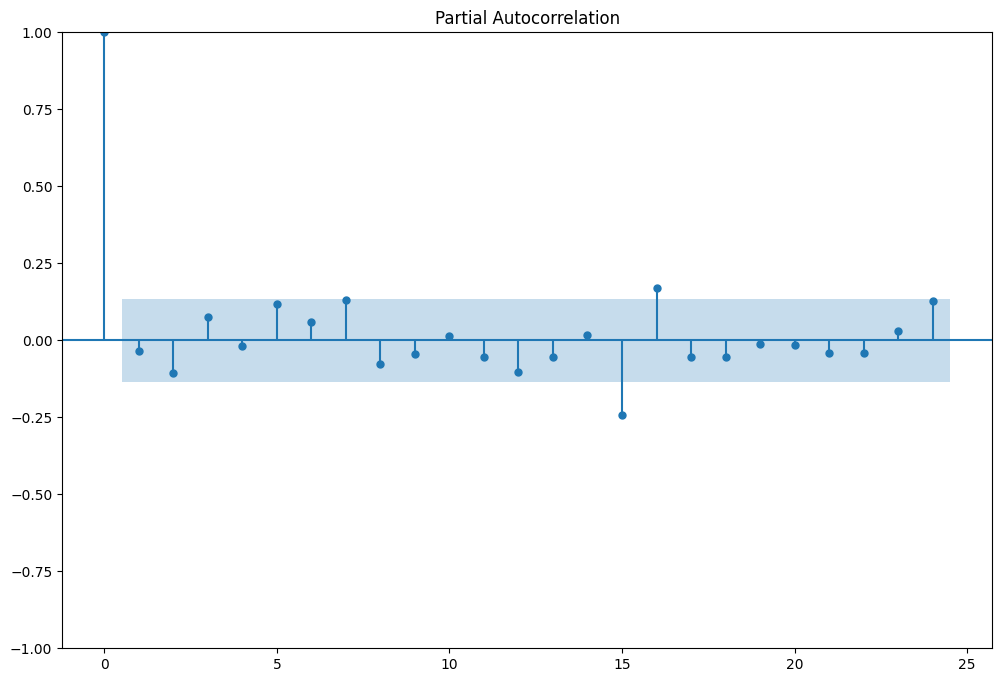

In [25]:
# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(diff_df);
plot_pacf(diff_df);

#### Observation
1. From ACF plot we can see that q values can be 15, 16 & 18
2 .From PACF plot we can see that p values can be 7,15,16 & 24444

### Time-SERIES FORECASTING

#### Exponential Smoothing:
Exponential smoothing is a time series forecasting method for univariate data. There are three main types of exponential smoothing time series forecasting methods. A simple method that assumes no systematic structure, an extension that explicitly handles trends, and the most advanced approach that add support for seasonality.

### Single Exponential Smoothing

Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

In [26]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<Axes: xlabel='Year'>

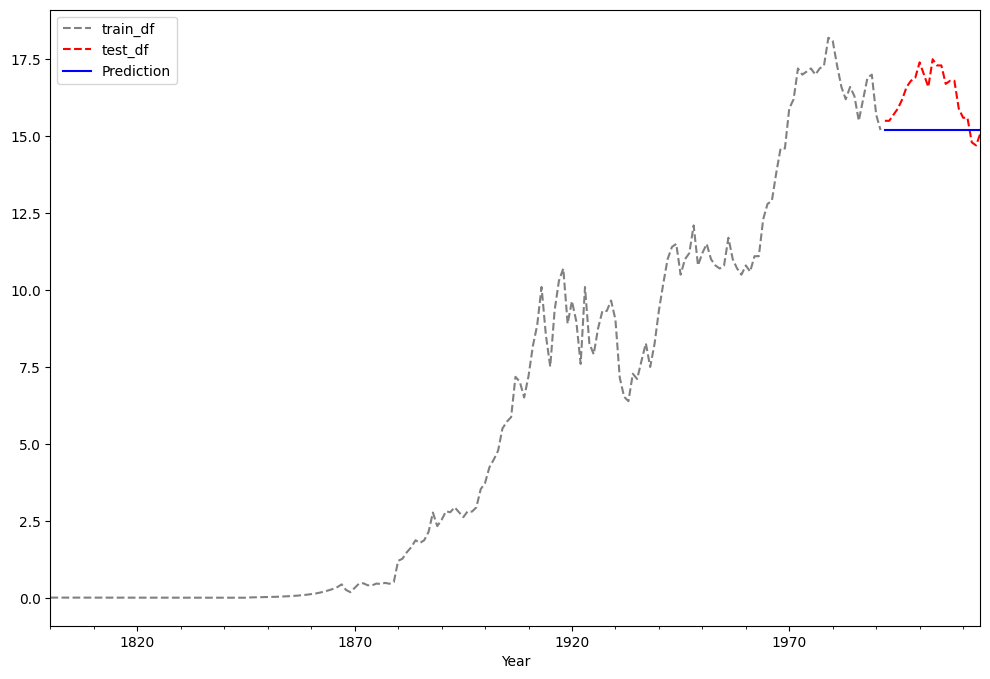

In [27]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [28]:
print('Train RMSE:',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE: 0.564692002680021
Test RMSE: 1.3429113022690744
Train MAPE: 0.08470457297144991
Test MAPE: 0.06861466412071275


### Double Exponential Smoothing

Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series

In [29]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

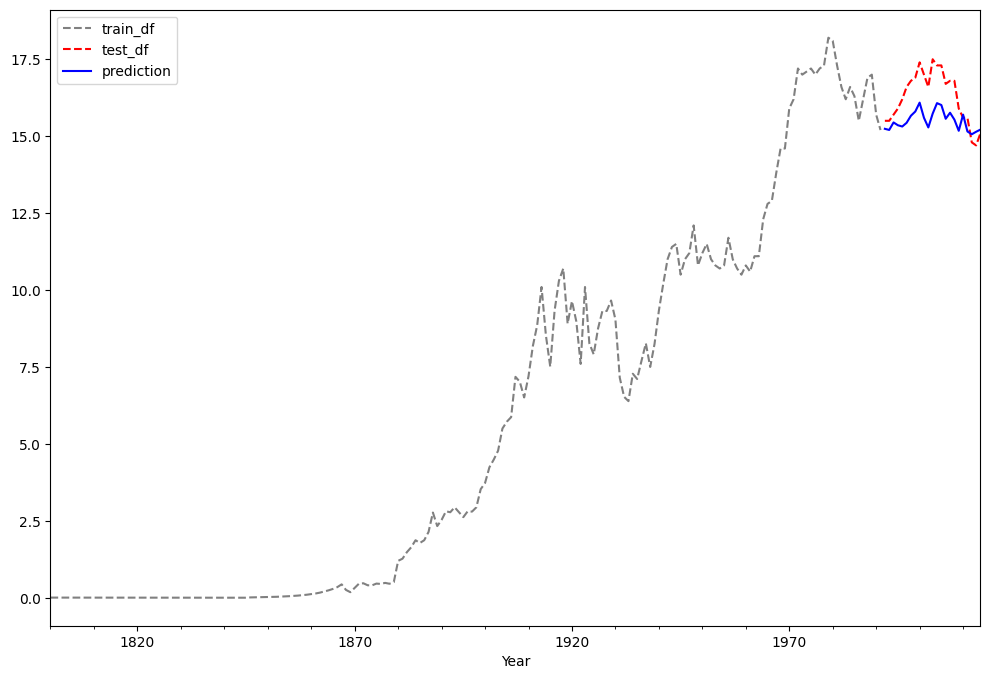

In [30]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [31]:
print('Train RMSE:',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE: 0.5576263311586229
Test RMSE: 0.9739218268464459
Train MAPE: 14.72268617058503
Test MAPE: 0.050781568455286974


### Triple Exponential Smoothing

Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series. Also known as Holt-Winters Exponential Smoothing

In [32]:
hw_model = ExponentialSmoothing(train_df['CO2'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=28, 
                          damped_trend=True).fit()
hw_train_pred =  hw_model.fittedvalues
hw_test_pred =  hw_model.forecast(23)

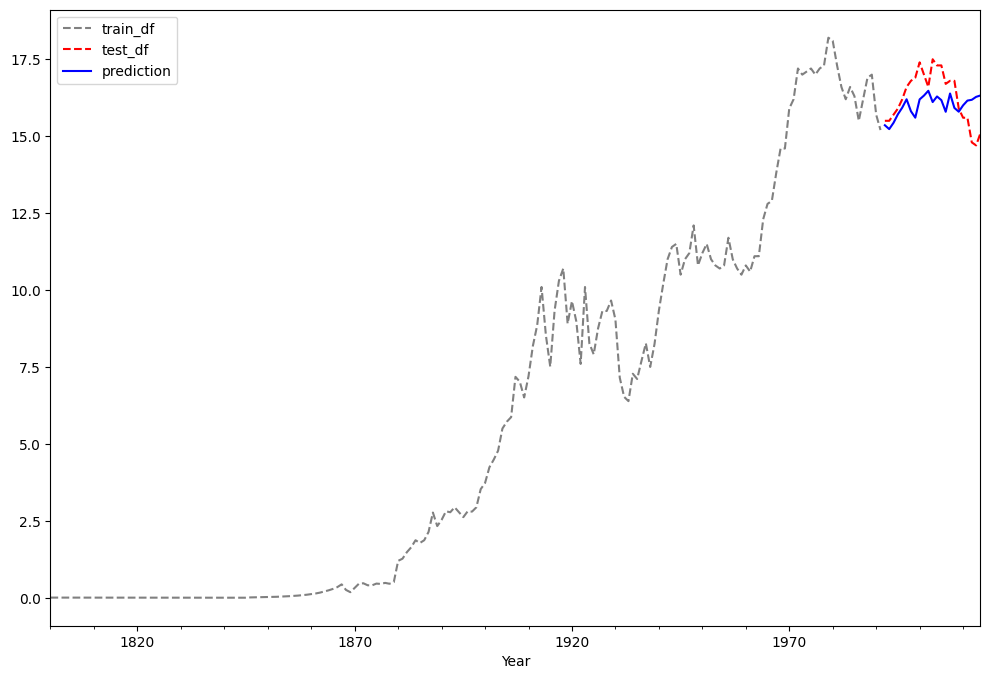

In [33]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
hw_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [34]:
print('Train RMSE:',mean_squared_error(train_df, hw_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, hw_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, hw_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, hw_test_pred))

Train RMSE: 0.5441327287420381
Test RMSE: 0.8698095177971306
Train MAPE: 16.2080906536108
Test MAPE: 0.044900018303271706


### ARIMA

A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. The parameters of the ARIMA model are defined as follows:
1. p : The number of lag observations included in the model, also called the lag order.
   2. 
d : The number of times that the raw observations are differenced, also called the degree of differencing
   .3. q : The size of the moving average window, also called the order of moving average.e.age.

In [35]:
# we got the p,d,q value from time series analysis
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

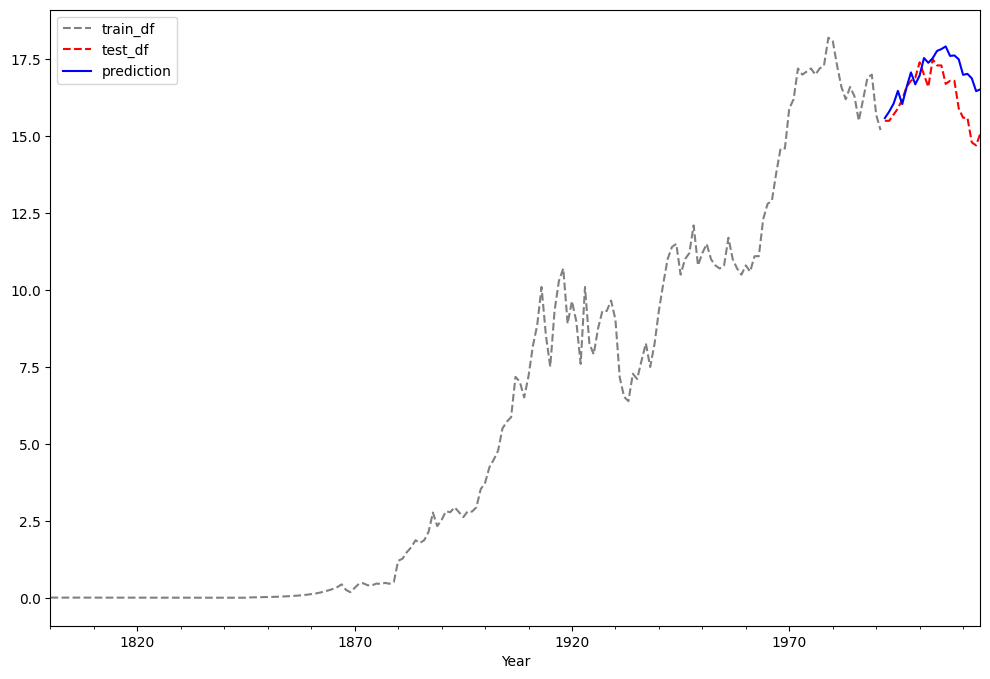

In [36]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [37]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 0.46787181220144347
Test RMSE: 0.958018632866733
Train MAPE: 0.08142994843403044
Test MAPE: 0.047514694027398205


### GRID SEARCH p, q, d values

From acf and pacf we got different potenstial p,q values. Lets use grid search to find the best pair out of them

In [39]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order):
    # prepare training dataset
    train_df = df.loc[:'1991-01-01']
    test_df = df.loc['1992-01-01':]
    # make predictions
    model = ARIMA(train_df, order=arima_order).fit()
    model_pred = model.forecast(23)
    rmse = (mean_squared_error(test_df, model_pred)**0.5)
    return rmse

In [40]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for q in q_values:
				order = (p,1,q)
				try:
					rmse = evaluate_arima_model(order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [41]:
# evaluate parameters
p_values = [7,15,16,24]
q_values = [15,16,18]

evaluate_models(df['CO2'].values, p_values, q_values)

Best ARIMA(16, 1, 16) RMSE=0.830


In [42]:
arima = ARIMA(train_df['CO2'], order=(16,1,16)).fit()
arima_train_pred = arima.predict()
arima_test_pred = arima.forecast(23)

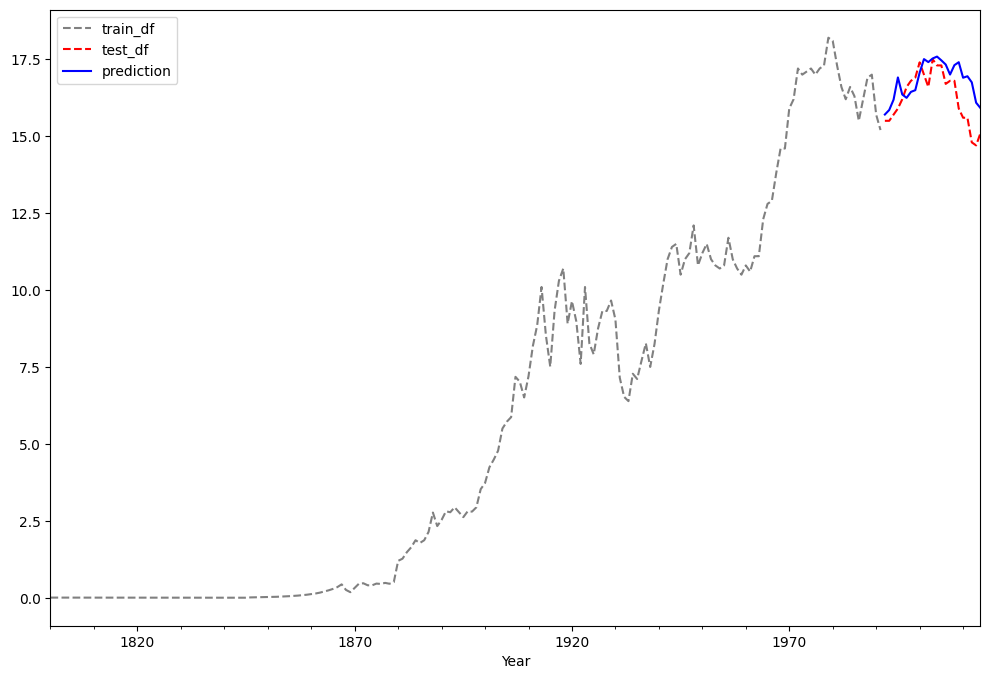

In [43]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [44]:
print('Train RMSE:',mean_squared_error(train_df, arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, arima_test_pred))

Train RMSE: 0.4577135042963754
Test RMSE: 0.8301975991755417
Train MAPE: 0.0809556325406582
Test MAPE: 0.04158393820645686


### Auto ARIMA

Although ARIMA is a very powerful model for forecasting time series data, the data preparation and parameter tuning processes end up being really time consuming. Before implementing ARIMA, you need to make the series stationary, and determine the values of p and q using the plots we discussed above. Auto ARIMA makes this task really simple for us as it eliminates many steps

In [45]:
auto_arima(df['CO2'], m=30, max_order= None, max_p=16, max_q=16, max_d=1,max_P=16, max_Q=16, max_D=2, maxiter=50, alpha=0.05, n_jobs=-1,information_criterion='aic', out_of_sample_size=30).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  215
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 30)   Log Likelihood                -171.435
Date:                            Wed, 04 Dec 2024   AIC                            348.870
Time:                                    15:17:18   BIC                            358.968
Sample:                                         0   HQIC                           352.950
                                            - 215                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0539      0.037      1.437      0.151      -0.020       0.127
ar.S.L30       0.1737      0.063      2.743      0.006       0.050       0.298
sigma2         0.2895      0.016     17.659      0.000       0.257       0.322
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               134.27
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              73.27   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# pass the order and seasonal order values we got from auto arima
sarima = SARIMAX(train_df['CO2'], order=(0,1,0), seasonal_order=(1,0,0,30)).fit()
sarima_train_pred = sarima.predict()
sarima_test_pred = sarima.forecast(23)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34762D-01    |proj g|=  2.59111D-01

At iterate    5    f=  8.27155D-01    |proj g|=  2.24130D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   3.011D-06   8.272D-01
  F =  0.82715473753632773     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


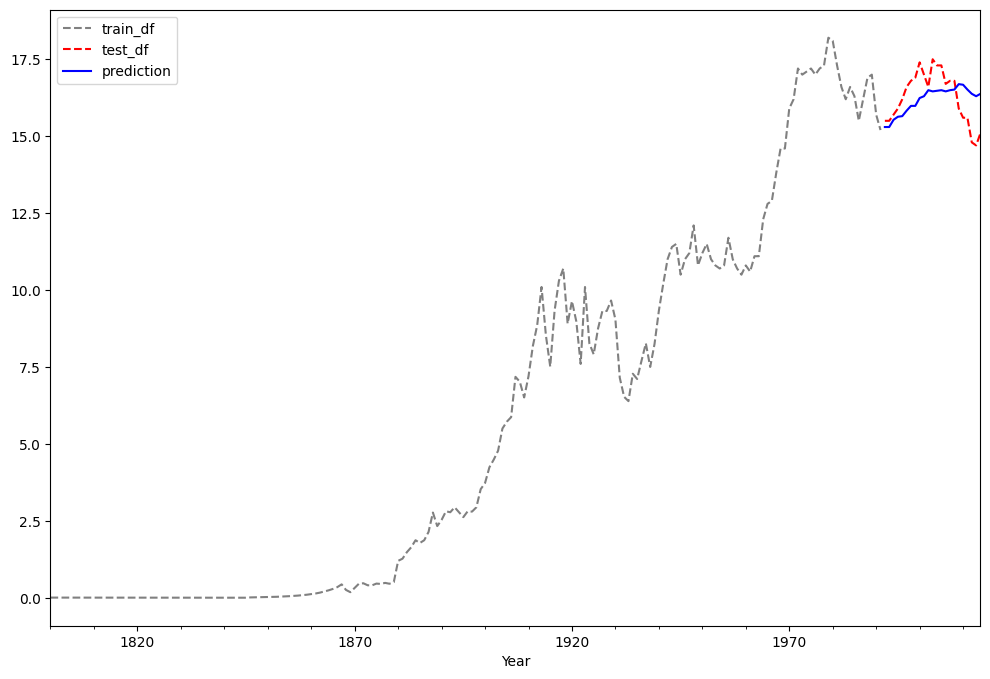

In [47]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
sarima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [48]:
print('Train RMSE:',mean_squared_error(train_df, sarima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, sarima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, sarima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, sarima_test_pred))

Train RMSE: 0.5525847291561847
Test RMSE: 0.8435901723912869
Train MAPE: 0.0879378051422293
Test MAPE: 0.04484283290980469


### PROPHET

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

In [49]:
# converting the original dataframe into required format by prophet
prophet_df = df.copy()
prophet_df.reset_index(inplace=True)
prophet_df.columns=['ds','y']
prophet_df.head()

,ds,y
0,1800-01-01,0.00568
1,1801-01-01,0.00561
2,1802-01-01,0.00555
3,1803-01-01,0.00548
4,1804-01-01,0.00542


In [50]:
# train test split data
prophet_train_df = prophet_df.iloc[:-23]
prophet_test_df = prophet_df.iloc[-23:]

In [51]:
prophet_model = Prophet()
prophet_model.fit(prophet_train_df) #fit training data to model

15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
future = prophet_model.make_future_dataframe(periods=23, freq='YS')
prophet_predictions = prophet_model.predict(future)

In [53]:
prophet_predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
210,2010-01-01,19.544006,18.473640,21.225732,19.406862,19.702097,0.315908,0.315908,0.315908,0.315908,0.315908,0.315908,0.0,0.0,0.0,19.859914
211,2011-01-01,19.685511,18.850759,21.708668,19.537198,19.855461,0.563536,0.563536,0.563536,0.563536,0.563536,0.563536,0.0,0.0,0.0,20.249047
212,2012-01-01,19.827017,19.153596,22.042118,19.667103,20.011299,0.811704,0.811704,0.811704,0.811704,0.811704,0.811704,0.0,0.0,0.0,20.638720
213,2013-01-01,19.968910,18.538839,21.531410,19.797013,20.171628,0.069124,0.069124,0.069124,0.069124,0.069124,0.069124,0.0,0.0,0.0,20.038034
214,2014-01-01,20.110416,18.981476,21.851671,19.927855,20.325157,0.315908,0.315908,0.315908,0.315908,0.315908,0.315908,0.0,0.0,0.0,20.426324


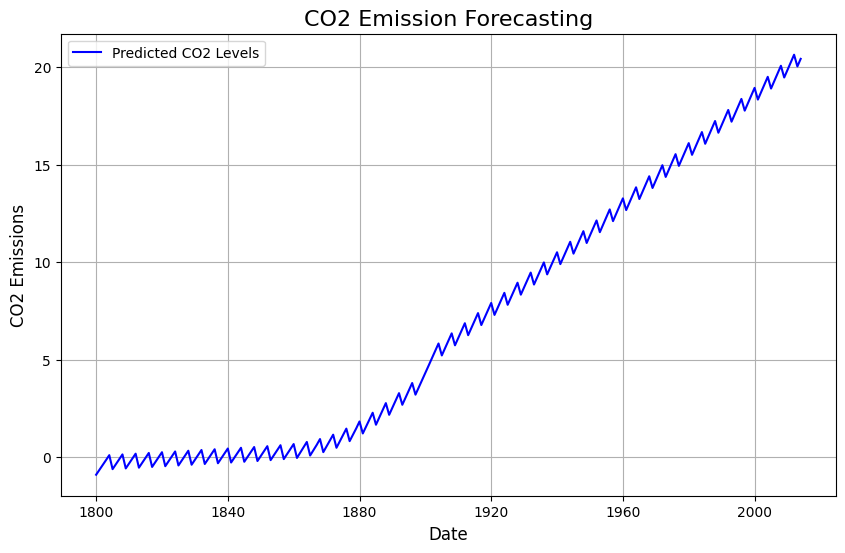

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.lineplot(x='ds', y='yhat', data=prophet_predictions, color='blue', label='Predicted CO2 Levels')

plt.title('CO2 Emission Forecasting', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 Emissions', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

In [57]:
prophet_train_df['prophet_train_pred'] = prophet_predictions.iloc[:-23]['yhat']
prophet_test_df['prophet_test_pred'] = prophet_predictions.iloc[-23:]['yhat']

In [58]:
print('Train RMSE:',mean_squared_error(prophet_train_df['y'], prophet_train_df['prophet_train_pred'])**0.5)
print('Test RMSE:',mean_squared_error(prophet_test_df['y'], prophet_test_df['prophet_test_pred'])**0.5)
print('Train MAPE:',mean_absolute_percentage_error(prophet_train_df['y'], prophet_train_df['prophet_train_pred']))
print('Test MAPE:',mean_absolute_percentage_error(prophet_test_df['y'], prophet_test_df['prophet_test_pred']))

Train RMSE: 1.1120074518632903
Test RMSE: 3.05591271614841
Train MAPE: 20.157913595323958
Test MAPE: 0.17085777585508993


### LSTM

LSTM stands for Long short-term memory. LSTM cells are used in recurrent neural networks that learn to predict the future from sequences of variable lengths. Note that recurrent neural networks work with any kind of sequential data and, unlike ARIMA and Prophet, are not restricted to time series.

Designing an optimal LSTM based model can be a difficult task that requires careful hyperparameter tuning.

In [59]:
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y)

In [60]:
x, y = df_to_x_y(df['CO2'], 29)
x.shape, y.shape

((186, 29, 1), (186,))

In [61]:
x_train_df, y_train_df = x[:-23], y[:-23]
x_test_df, y_test_df = x[-23:], y[-23:]
x_train_df.shape, y_train_df.shape, x_test_df.shape, y_test_df.shape

((163, 29, 1), (163,), (23, 29, 1), (23,))

In [62]:
lstm = Sequential()
lstm.add(InputLayer((30,1)))
lstm.add(LSTM(20))
lstm.add(Dense(10,'relu'))
lstm.add(Dense(5,'relu'))
lstm.add(Dense(1,'linear'))

lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,031 (7.93 KB)

 Trainable params: 2,031 (7.93 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
cp1 = ModelCheckpoint('lstm/model_best.keras', save_best_only=True)
lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

In [66]:
lstm.fit(x_train_df, y_train_df, epochs=100, callbacks=[cp1])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 54.2470 - root_mean_squared_error: 7.3066
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2360 - root_mean_squared_error: 3.0269 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7686 - root_mean_squared_error: 2.1832
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9331 - root_mean_squared_error: 1.9686
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0567 - root_mean_squared_error: 2.0113
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9234 - root_mean_squared_error: 0.9606
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8810 - root_mean_squared_error: 1.3568
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9658 - root_mean_squared_error: 1.7205
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4826 - root_mean_squared_error: 1.5711
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1242 - root_mean_squared_error: 1.4457
Epoch 1

In [67]:
test_predictions = lstm.predict(x_test_df).flatten()
test_df['lstm_pred'] = test_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


<Axes: xlabel='Year'>

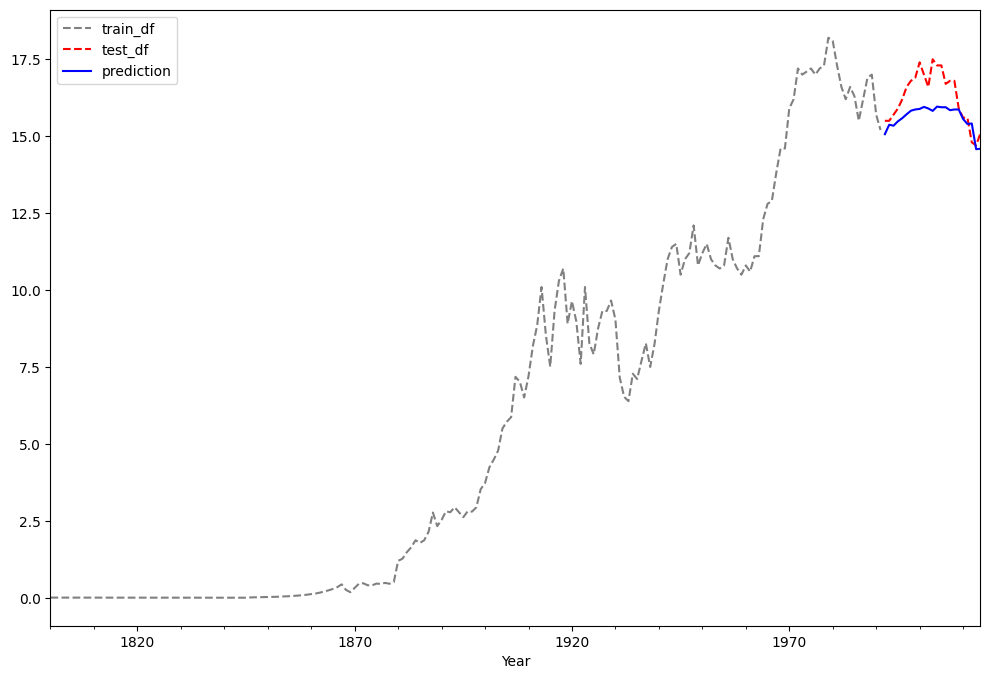

In [68]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
test_df['lstm_pred'].plot(color='b', legend=True, label='prediction')

In [69]:
print('Test RMSE:',mean_squared_error(test_df['CO2'], test_df['lstm_pred'])**0.5)
print('Test MAPE:',mean_absolute_percentage_error(test_df['CO2'], test_df['lstm_pred']))

Test RMSE: 0.8613376565721048
Test MAPE: 0.04334598456292464


### MODELS COMPARISION

In [70]:
comparision_df = pd.DataFrame(data=[['Single exp smoothing', 1.3429 , 0.0686],
                           ['double exp smoothing', 0.5352,  0.0260],
                          ['Triple exp smoothing', 1.0377, 0.0447],
                          ['ARIMA(15,1,15)', 0.9591, 0.0475],
                          ['ARIMA(16,1,16)', 0.8337, 0.0417],
                          ['SARIMA(0,1,0)(1,0,0,30)', 0.8435, 0.0448],
                          ['prophet', 2.9893, 0.1665],
                          ['LSTM', 0.9939, 0.05592]], columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)

In [71]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
double exp smoothing,0.5352,0.02600
"ARIMA(16,1,16)",0.8337,0.04170
"SARIMA(0,1,0)(1,0,0,30)",0.8435,0.04480
"ARIMA(15,1,15)",0.9591,0.04750
LSTM,0.9939,0.05592
Triple exp smoothing,1.0377,0.04470
Single exp smoothing,1.3429,0.06860
prophet,2.9893,0.16650


#### Analysis:
1. We can clearly see that double exponential smoothing model is performing best among all other models
   2. Weu must try playing with model parameters, try to understand them and tune them andweu'll see improvement in your model..

Now let's train the best performing model (LSTM) on complete data, so it can predict data after 2014

In [72]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(20)

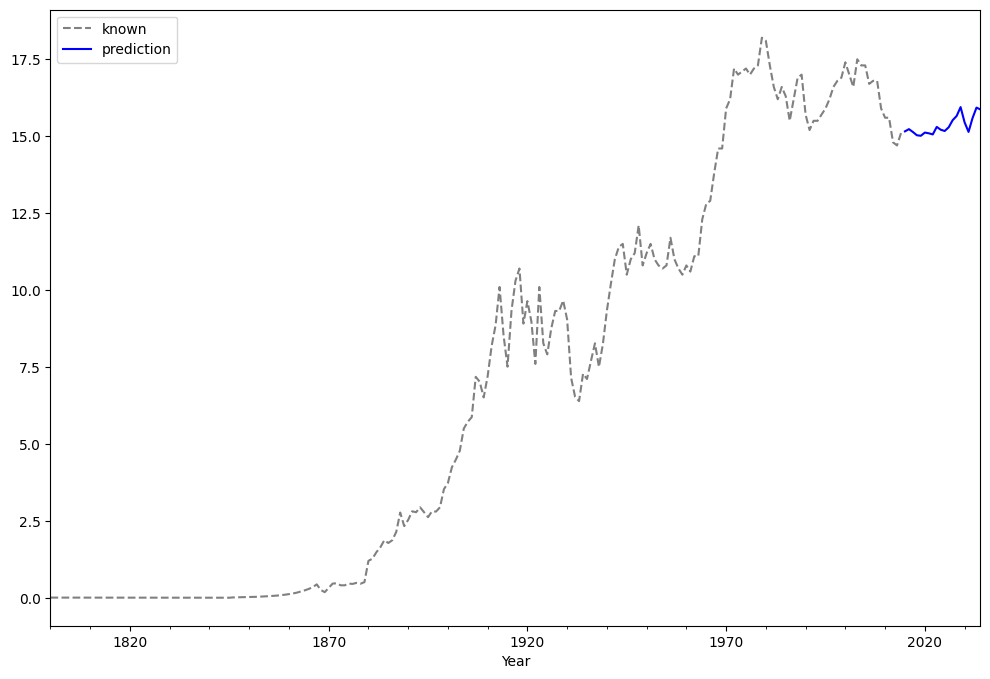

In [73]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [74]:
pickle.dump(double_exp, open('forecast_model.pickle','wb'))

#### DEPLOYMENT 

* To deploy any file, it should be in .py format* 
Make a .py file and Put code for front and backhand inside .py file

%%writefile command will convert all the code within this cell into .py file

In [85]:
%%writefile co2_forecasting_app.py

# Importing necessary libraries
import pickle
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Load the pre-trained model
model = pickle.load(open('forecast_model.pickle', 'rb'))

# Load the dataset
df = pd.read_excel("CO2 dataset.xlsx")
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index(['Year'], inplace=True)

# Set Streamlit app configuration
st.set_page_config(layout='centered')
image = Image.open('Add_a_heading.jpg')
st.image(image)

# Slider for year input
year = st.slider("Select number of Years", 1, 30, step=1)

# Forecast prediction
pred = model.forecast(year)
pred = pd.DataFrame(pred, columns=['CO2'])

# Predict and display results
if st.button("Predict"):
    col1, col2 = st.columns([2, 3])
    with col1:
        st.dataframe(pred)
    with col2:
        fig, ax = plt.subplots()
        df['CO2'].plot(style='--', color='gray', legend=True, label='known')
        pred['CO2'].plot(color='b', legend=True, label='prediction')
        st.pyplot(fig)



Overwriting co2_forecasting_app.py


When we'll run following cell, it will display a UI in our terminal with public URL of our tunnel and other status and metrics information about connections made over our tunnel